In [53]:
import pandas as pd
import random as rndm
from random import choice
import operator as op
from sklearn import preprocessing as pp
from sklearn.model_selection import cross_val_score as validate_model
from sklearn.neighbors import KNeighborsClassifier as NeighborModel
from sklearn.metrics import accuracy_score as acc_metric
from scipy.stats import ttest_rel as paired_t_test
from statistics import mean as avg_value


In [54]:
class DistanceMetricsHandler:
    def calc_euclidean(self, point1, point2):
        dist_val = 0.0
        for idx in range(len(point1)-1):
            dist_val += (point1[idx] - point2[idx])**2
        return (dist_val)**0.5

    def calc_manhattan(self, point1, point2):
        return sum(abs(val1 - val2) for val1, val2 in zip(point1, point2))

    def calc_hamming(self, point1, point2):
        return sum(val1 != val2 for val1, val2 in zip(point1, point2))


In [55]:
class NeighborPredictor:
    def __init__(self, num_neighbors=3, metric_choice='euclidean'):
        self.num_neighbors = num_neighbors
        self.metric_choice = metric_choice

    def model_fit(self, input_data, output_labels):
        assert len(input_data) == len(output_labels)
        self.data_input = input_data
        self.data_labels = output_labels

    def compute_distances(self, sample_point):
        metrics_module = DistanceMetricsHandler()  
        calculated_distances = []
        
        for index, single_data in enumerate(self.data_input):
            if self.metric_choice == 'euclidean':
                calculated_distances.append([single_data, metrics_module.calc_euclidean(sample_point, single_data), self.data_labels[index]])
            elif self.metric_choice == 'manhattan':
                calculated_distances.append([single_data, metrics_module.calc_manhattan(sample_point, single_data), self.data_labels[index]])
            elif self.metric_choice == 'hamming':
                calculated_distances.append([single_data, metrics_module.calc_hamming(sample_point, single_data), self.data_labels[index]])
            else:
                raise ValueError(f"Unknown metric type: {self.metric_choice}")
        
        calculated_distances.sort(key=op.itemgetter(1))
        
        selected_neighbors = []
        for idx in range(self.num_neighbors):
            selected_neighbors.append(calculated_distances[idx])
        
        return selected_neighbors

    def calculate_votes(self, selected_neighbors):
        voting_scores = {}
        for each_neighbor in selected_neighbors:
            label_class = each_neighbor[2] 
            dist_value = each_neighbor[1] 
            weighted_val = 1 / (dist_value + 1e-5) 

            if isinstance(label_class, list):  
                for individual_label in label_class:
                    if individual_label in voting_scores:
                        voting_scores[individual_label] += weighted_val
                    else:
                        voting_scores[individual_label] = weighted_val
            else:
                if label_class in voting_scores:
                    voting_scores[label_class] += weighted_val
                else:
                    voting_scores[label_class] = weighted_val

        sorted_scores = sorted(voting_scores.items(), key=lambda x: x[1], reverse=True)
        highest_score_label = sorted_scores[0][0]
        return highest_score_label

    def make_predictions(self, test_samples, num_neighbors=None, metric_choice=None):
        if num_neighbors:
            self.num_neighbors = num_neighbors
        if metric_choice:
            self.metric_choice = metric_choice

        final_predictions = []
        for each_sample in test_samples:
            nearest_neighbors = self.compute_distances(each_sample)
            prediction_result = self.calculate_votes(nearest_neighbors)
            final_predictions.append(prediction_result)

        return final_predictions


In [56]:
def display_results(true_labels, predicted_labels):
    match_count = 0
    for z in range(len(true_labels)):
        if true_labels[z] == predicted_labels[z]:
            match_count += 1
    return (match_count / float(len(true_labels)))


In [57]:
class DataSplitter:
    def random_split(self, records, num_parts):
        divided_data = list()
        temp_data = list(records)
        part_length = int(len(records) / num_parts)
        for section_num in range(num_parts):
            section = list()
            while len(section) < part_length:
                random_index = choice(range(len(temp_data)))
                section.append(temp_data.pop(random_index))
            divided_data.append(section)
        return divided_data

    def assess_model(self, records, num_parts, neighbors_total, metric_types):
        knn_instance = NeighborPredictor()
        split_records = self.random_split(records, num_parts)
        
        custom_outcomes = {metric: [] for metric in metric_types}
        sklearn_outcomes = {metric: [] for metric in metric_types}

        
        for section in split_records:
            training_data = list(split_records)
            training_data.remove(section)
            training_data = sum(training_data, [])
            testing_data = list()
            for item in section:
                item_copy = list(item)
                testing_data.append(item_copy)

            label_training = [item[-1] for item in training_data]
            training_data = [train[:-1] for train in training_data]
            label_testing = [item[-1] for item in testing_data]
            testing_data = [test[:-1] for test in testing_data]

            for metric in metric_types:
                knn_instance.model_fit(training_data, label_training)
                predicted_vals = knn_instance.make_predictions(testing_data, neighbors_total, metric)
                result_accuracy = display_results(label_testing, predicted_vals)
                custom_outcomes[metric].append(result_accuracy)

                
                sklearn_knn_instance = NeighborModel(n_neighbors=neighbors_total, metric=metric)
                sklearn_knn_instance.fit(training_data, label_training)
                sklearn_preds = sklearn_knn_instance.predict(testing_data)
                sklearn_accuracy_res = acc_metric(label_testing, sklearn_preds)
                sklearn_outcomes[metric].append(sklearn_accuracy_res)

        return custom_outcomes, sklearn_outcomes


In [58]:
def fetch_records(data_file):
    features_list = []
    target_values = []

    with open(data_file, "r") as opened_file:
        file_content = opened_file.readlines()
    for entry in file_content:
        row_items = entry.strip().split(',')
        features_list.append(row_items)
        target_values.append(row_items[-1])
    return features_list, target_values


<div class="alert alert-block alert-warning">
    <bold><b><h1>1. Hayes Roth Dataset</bold></b> 
</div>

In [59]:
input_file = 'hayes-roth.data'
raw_data, class_labels = fetch_records(input_file)
final_features = []

for line in raw_data:
    feature_slice = line[1:]
    numeric_features = [int(element) for element in feature_slice]
    final_features.append(numeric_features)

final_labels = [int(classification) for classification in class_labels]


In [60]:
data_validator = DataSplitter()


In [61]:

metric_types = ['euclidean', 'hamming', 'manhattan']


custom_scores, sklearn_scores = data_validator.assess_model(final_features, 10, 3, metric_types)


for metric in metric_types:
   
    mean_custom_knn = sum(custom_scores[metric]) / len(custom_scores[metric])
    mean_sklearn_knn = sum(sklearn_scores[metric]) / len(sklearn_scores[metric])

    
    print(f"\n{metric.capitalize()}:")

    
    print("List of all Custom KNN values:")
    print([f"{score:}" for score in custom_scores[metric]])

    
    print("List of all Scikit-learn KNN values:")
    print([f"{score:}" for score in sklearn_scores[metric]])

    
    print(f"Mean Accuracy of Custom KNN: {mean_custom_knn * 100:.2f}%")

   
    print(f"Mean Accuracy of Scikit-learn KNN: {mean_sklearn_knn * 100:.2f}%")



Euclidean:
List of all Custom KNN values:
['0.46153846153846156', '0.46153846153846156', '0.46153846153846156', '0.6923076923076923', '0.6923076923076923', '0.3076923076923077', '0.46153846153846156', '0.6153846153846154', '0.38461538461538464', '0.5384615384615384']
List of all Scikit-learn KNN values:
['0.6923076923076923', '0.46153846153846156', '0.5384615384615384', '0.7692307692307693', '0.8461538461538461', '0.46153846153846156', '0.7692307692307693', '0.6923076923076923', '0.6923076923076923', '0.7692307692307693']
Mean Accuracy of Custom KNN: 50.77%
Mean Accuracy of Scikit-learn KNN: 66.92%

Hamming:
List of all Custom KNN values:
['0.6153846153846154', '0.46153846153846156', '0.38461538461538464', '0.7692307692307693', '0.7692307692307693', '0.3076923076923077', '0.6153846153846154', '0.6923076923076923', '0.6153846153846154', '0.6153846153846154']
List of all Scikit-learn KNN values:
['0.5384615384615384', '0.46153846153846156', '0.23076923076923078', '0.6923076923076923', '

In [62]:
for metric in metric_types:
    print(f"\n{metric.capitalize()}:")
    
    
    t_statistic, p_value = paired_t_test(custom_scores[metric], sklearn_scores[metric])
    
    
    print(f'T-statistic: {t_statistic:.4f}')
    print(f'P-value: {p_value:.4f}')
    
    
    if p_value > 0.05:
        print("Fail to reject the null hypothesis (No significant difference between the models).")
    else:
        print("Reject the null hypothesis (Significant difference between the models).")
        
    print("--------------------------------------------------------------------------------------")



Euclidean:
T-statistic: -4.8462
P-value: 0.0009
Reject the null hypothesis (Significant difference between the models).
--------------------------------------------------------------------------------------

Hamming:
T-statistic: 0.6124
P-value: 0.5554
Fail to reject the null hypothesis (No significant difference between the models).
--------------------------------------------------------------------------------------

Manhattan:
T-statistic: -1.8605
P-value: 0.0957
Fail to reject the null hypothesis (No significant difference between the models).
--------------------------------------------------------------------------------------


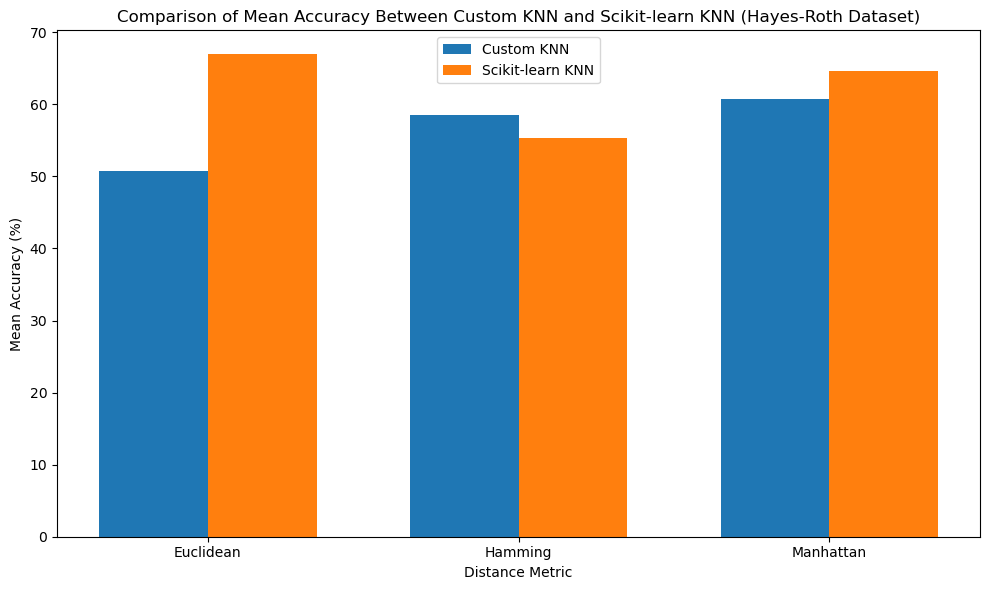

In [63]:
import matplotlib.pyplot as plt


metrics = [metric.capitalize() for metric in metric_types]
custom_means = [sum(custom_scores[metric]) / len(custom_scores[metric]) * 100 for metric in metric_types]
sklearn_means = [sum(sklearn_scores[metric]) / len(sklearn_scores[metric]) * 100 for metric in metric_types]


plt.figure(figsize=(10, 6))
bar_width = 0.35
index = range(len(metrics))


plt.bar(index, custom_means, bar_width, label='Custom KNN')
plt.bar([i + bar_width for i in index], sklearn_means, bar_width, label='Scikit-learn KNN')


plt.xlabel('Distance Metric')
plt.ylabel('Mean Accuracy (%)')
plt.title('Comparison of Mean Accuracy Between Custom KNN and Scikit-learn KNN (Hayes-Roth Dataset)')
plt.xticks([i + bar_width / 2 for i in index], metrics)
plt.legend()


plt.tight_layout()
plt.show()


<div class="alert alert-block alert-warning">
    <bold><b><h1>2. Car Dataset</bold></b> 
</div>

In [64]:
car_dataset = 'car.data'
car_content, car_labels_raw = fetch_records(car_dataset)
data_frame = pd.DataFrame(car_content)
data_frame = data_frame.apply(pp.LabelEncoder().fit_transform)
car_features_processed = data_frame.values.tolist()
car_final_labels = [entry[-1] for entry in car_features_processed]


In [65]:
metric_options = ['euclidean', 'hamming', 'manhattan']
car_custom_results, car_sklearn_results = data_validator.assess_model(car_features_processed, 10, 3, metric_options)


for metric in metric_options:
    
    
    avg_custom_knn = sum(car_custom_results[metric]) / len(car_custom_results[metric])
    avg_sklearn_knn = sum(car_sklearn_results[metric]) / len(car_sklearn_results[metric])
    
    
    print(f"\n{metric.capitalize()}:")

    
    print("List of all Custom KNN values:")
    print([f"{score:}" for score in car_custom_results[metric]])

    
    print("List of all Scikit-learn KNN values:")
    print([f"{score:}" for score in car_sklearn_results[metric]])

    
    print(f"Mean Accuracy of Custom KNN: {avg_custom_knn * 100:.2f}%")

    
    print(f"Mean Accuracy of Scikit-learn KNN: {avg_sklearn_knn * 100:.2f}%")



Euclidean:
List of all Custom KNN values:
['0.5755813953488372', '0.5523255813953488', '0.6395348837209303', '0.6569767441860465', '0.5988372093023255', '0.627906976744186', '0.6046511627906976', '0.627906976744186', '0.6337209302325582', '0.5930232558139535']
List of all Scikit-learn KNN values:
['0.8488372093023255', '0.8837209302325582', '0.8488372093023255', '0.872093023255814', '0.8953488372093024', '0.8662790697674418', '0.8372093023255814', '0.872093023255814', '0.8255813953488372', '0.7965116279069767']
Mean Accuracy of Custom KNN: 61.10%
Mean Accuracy of Scikit-learn KNN: 85.47%

Hamming:
List of all Custom KNN values:
['0.7906976744186046', '0.8372093023255814', '0.8255813953488372', '0.8604651162790697', '0.872093023255814', '0.8546511627906976', '0.8313953488372093', '0.8255813953488372', '0.8430232558139535', '0.8488372093023255']
List of all Scikit-learn KNN values:
['0.8313953488372093', '0.872093023255814', '0.8313953488372093', '0.9011627906976745', '0.843023255813953

In [66]:
for metric in metric_options:
    print(f"\n{metric.capitalize()}:")
    
   
    t_statistic, p_value = paired_t_test(car_custom_results[metric], car_sklearn_results[metric])
    
   
    print(f'T-statistic: {t_statistic:.4f}')
    print(f'P-value: {p_value:.4f}')
    

    if p_value > 0.05:
        print("Fail to reject the null hypothesis (No significant difference between the models).")
    else:
        print("Reject the null hypothesis (Significant difference between the models).")
        
    print("--------------------------------------------------------------------------------------")



Euclidean:
T-statistic: -17.3169
P-value: 0.0000
Reject the null hypothesis (Significant difference between the models).
--------------------------------------------------------------------------------------

Hamming:
T-statistic: -1.7652
P-value: 0.1113
Fail to reject the null hypothesis (No significant difference between the models).
--------------------------------------------------------------------------------------

Manhattan:
T-statistic: 1.4717
P-value: 0.1752
Fail to reject the null hypothesis (No significant difference between the models).
--------------------------------------------------------------------------------------


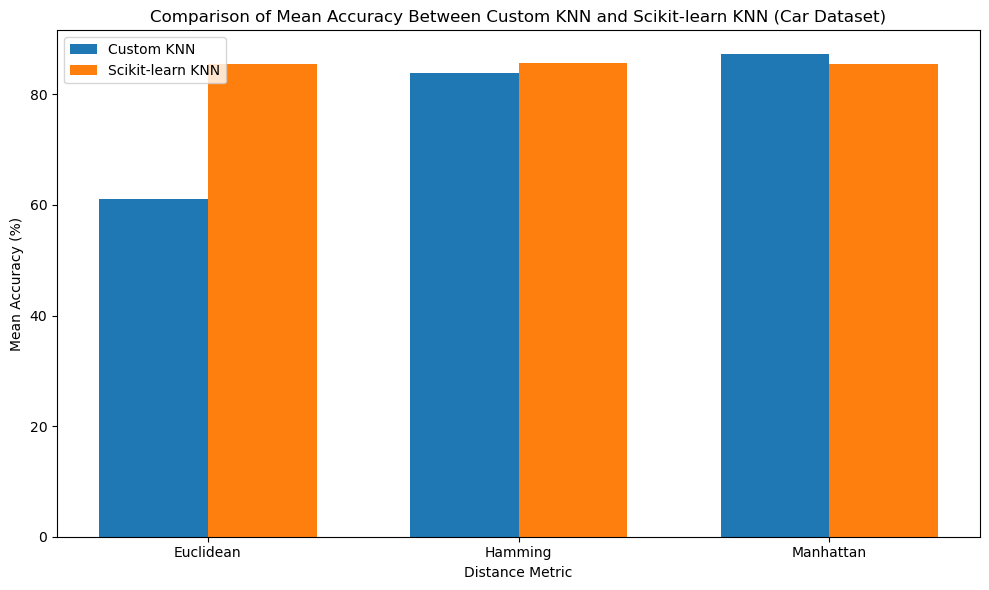

In [67]:
import matplotlib.pyplot as plt


metrics = [metric.capitalize() for metric in metric_options]
custom_means = [sum(car_custom_results[metric]) / len(car_custom_results[metric]) * 100 for metric in metric_options]
sklearn_means = [sum(car_sklearn_results[metric]) / len(car_sklearn_results[metric]) * 100 for metric in metric_options]


plt.figure(figsize=(10, 6))
bar_width = 0.35
index = range(len(metrics))


plt.bar(index, custom_means, bar_width, label='Custom KNN')
plt.bar([i + bar_width for i in index], sklearn_means, bar_width, label='Scikit-learn KNN')


plt.xlabel('Distance Metric')
plt.ylabel('Mean Accuracy (%)')
plt.title('Comparison of Mean Accuracy Between Custom KNN and Scikit-learn KNN (Car Dataset)')
plt.xticks([i + bar_width / 2 for i in index], metrics)
plt.legend()


plt.tight_layout()
plt.show()


<div class="alert alert-block alert-warning">
    <bold><b><h1>3. Breast Cancer Dataset</bold></b> 
</div>

In [68]:
cancer_file_path = 'breast-cancer.data'
raw_cancer_data, initial_cancer_labels = fetch_records(cancer_file_path)
transformed_cancer_df = pd.DataFrame(raw_cancer_data)
transformed_cancer_df = transformed_cancer_df.apply(pp.LabelEncoder().fit_transform)
transformed_cancer_df.dropna(inplace=True)
final_cancer_features = transformed_cancer_df.values.tolist()
final_cancer_labels = [row[-1] for row in final_cancer_features]


In [73]:
metric_options = ['euclidean', 'hamming', 'manhattan']
custom_cancer_scores, sklearn_cancer_scores = data_validator.assess_model(final_cancer_features, 10, 3, metric_options)


for metric in metric_options:
   
    avg_custom_knn = sum(custom_cancer_scores[metric]) / len(custom_cancer_scores[metric])
    avg_sklearn_knn = sum(sklearn_cancer_scores[metric]) / len(sklearn_cancer_scores[metric])
    
    
    print(f"\n{metric.capitalize()}:")

    
    print("List of all Custom KNN values:")
    print([f"{score:}" for score in custom_cancer_scores[metric]])

    
    print("List of all Scikit-learn KNN values:")
    print([f"{score:}" for score in sklearn_cancer_scores[metric]])

   
    print(f"Mean Accuracy of Custom KNN: {avg_custom_knn * 100:.2f}%")

   
    print(f"Mean Accuracy of Scikit-learn KNN: {avg_sklearn_knn * 100:.2f}%")



Euclidean:
List of all Custom KNN values:
['0.75', '0.8214285714285714', '0.75', '0.6785714285714286', '0.7142857142857143', '0.6071428571428571', '0.8214285714285714', '0.7142857142857143', '0.7142857142857143', '0.7857142857142857']
List of all Scikit-learn KNN values:
['0.75', '0.8214285714285714', '0.6785714285714286', '0.6428571428571429', '0.7857142857142857', '0.6785714285714286', '0.7857142857142857', '0.7142857142857143', '0.8214285714285714', '0.7857142857142857']
Mean Accuracy of Custom KNN: 73.57%
Mean Accuracy of Scikit-learn KNN: 74.64%

Hamming:
List of all Custom KNN values:
['0.8571428571428571', '0.7857142857142857', '0.7857142857142857', '0.5', '0.6785714285714286', '0.75', '0.75', '0.7142857142857143', '0.6785714285714286', '0.9285714285714286']
List of all Scikit-learn KNN values:
['0.8928571428571429', '0.7857142857142857', '0.7857142857142857', '0.5714285714285714', '0.6785714285714286', '0.6428571428571429', '0.75', '0.6785714285714286', '0.6428571428571429', '

In [75]:
for metric in metric_options:
    print(f"\n{metric.capitalize()}:")
    
    
    t_statistic, p_value = paired_t_test(custom_cancer_scores[metric], sklearn_cancer_scores[metric])
    
    
    print(f'T-statistic: {t_statistic:.4f}')
    print(f'P-value: {p_value:.4f}')
    
    
    if p_value > 0.05:
        print("Fail to reject the null hypothesis, No significant difference between the model).")
    else:
        print("Reject the null hypothesis, Significant difference between the models.")
        
    print("--------------------------------------------------------------------------------------")



Euclidean:
T-statistic: -0.6054
P-value: 0.5599
Fail to reject the null hypothesis, No significant difference between the model).
--------------------------------------------------------------------------------------

Hamming:
T-statistic: 0.7093
P-value: 0.4961
Fail to reject the null hypothesis, No significant difference between the model).
--------------------------------------------------------------------------------------

Manhattan:
T-statistic: -0.1483
P-value: 0.8853
Fail to reject the null hypothesis, No significant difference between the model).
--------------------------------------------------------------------------------------


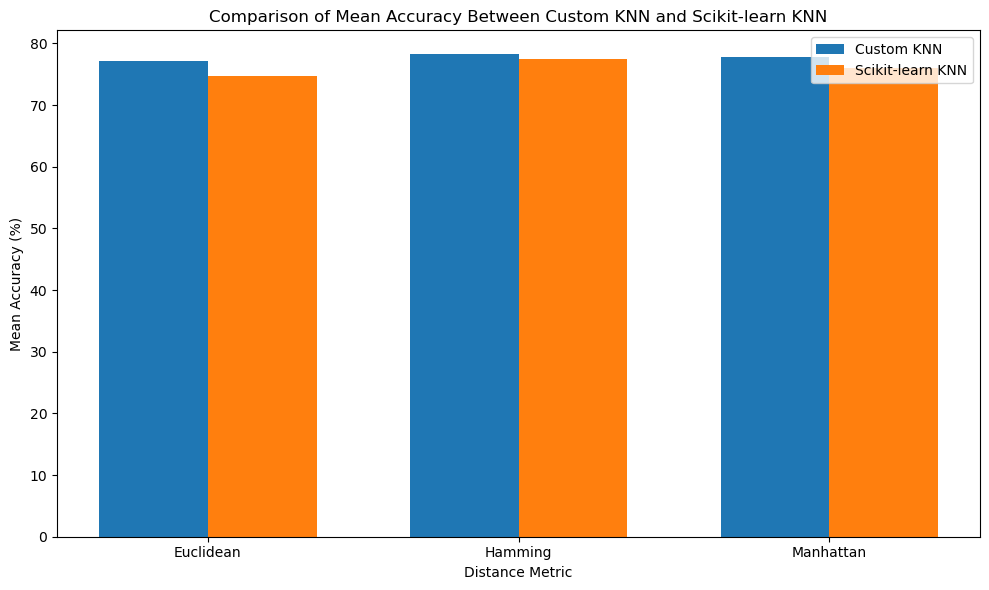

In [71]:
import matplotlib.pyplot as plt


metrics = [metric.capitalize() for metric in metric_options]
custom_means = [sum(custom_cancer_scores[metric]) / len(custom_cancer_scores[metric]) * 100 for metric in metric_options]
sklearn_means = [sum(sklearn_cancer_scores[metric]) / len(sklearn_cancer_scores[metric]) * 100 for metric in metric_options]


plt.figure(figsize=(10, 6))
bar_width = 0.35
index = range(len(metrics))


plt.bar(index, custom_means, bar_width, label='Custom KNN')
plt.bar([i + bar_width for i in index], sklearn_means, bar_width, label='Scikit-learn KNN')


plt.xlabel('Distance Metric')
plt.ylabel('Mean Accuracy (%)')
plt.title('Comparison of Mean Accuracy Between Custom KNN and Scikit-learn KNN')
plt.xticks([i + bar_width / 2 for i in index], metrics)
plt.legend()


plt.tight_layout()
plt.show()
